In [1]:
from pathlib import Path
import torch
 

import sys 
sys.path.append("/home/franka_deoxys/diffusion_policy")



import os
import pathlib
import click
import hydra
import torch
import dill
import wandb
import json
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.env_runner.robomimic_image_runner import RobomimicImageRunner

 
import numpy as np 
import collections 
import tqdm
import h5py
import math 
import wandb.sdk.data_types.video as wv
from diffusion_policy.gym_util.async_vector_env import AsyncVectorEnv
from diffusion_policy.gym_util.sync_vector_env import SyncVectorEnv
from diffusion_policy.gym_util.multistep_wrapper import MultiStepWrapper
from diffusion_policy.gym_util.video_recording_wrapper import VideoRecordingWrapper, VideoRecorder
from diffusion_policy.model.common.rotation_transformer import RotationTransformer

from diffusion_policy.policy.base_image_policy import BaseImagePolicy
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.env_runner.base_image_runner import BaseImageRunner
from diffusion_policy.env.robomimic.robomimic_image_wrapper import RobomimicImageWrapper
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils 
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace

import h5py
import matplotlib.pyplot as plt



import numpy as np
import matplotlib.pyplot as plt
import tqdm


import os
from pathlib import Path

import cv2
import numpy as np

sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")

from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
# from deoxys.utils import RobotStateRawObsDictGenerator, YamlConfig
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger


from threading import Thread
import time

from collections import OrderedDict

import torch

from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
pybullet build time: Nov 28 2023 23:52:03


In [2]:
from collections import defaultdict, deque

class FrameStackForTrans:
    def __init__(self, num_frames):
        self.num_frames = num_frames
        self.obs_history = {}
        
    def reset(self, init_obs):
        """ 
        init_obs: dict of initial observation at the start of the episode
        return stacked obs by repeating the first observation num_frames times
        """
        
        self.obs_history = {}
        for k in init_obs:
            self.obs_history[k] = deque([init_obs[k][None] for _ in range(self.num_frames)], maxlen=self.num_frames,)
        obs = { k : np.concatenate(self.obs_history[k], axis=0) for k in self.obs_history }
        return obs 

    def add_new_obs(self, new_obs):
        """ 
        new_obs: dict of new observation at current timestep
        return stacked obs
        """
        for k in new_obs:
            if 'timesteps' in k or 'actions' in k: continue
            self.obs_history[k].append(new_obs[k][None])

        obs= { k : np.concatenate(self.obs_history[k], axis=0) for k in self.obs_history }
        return obs 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class BaseRawObsDictGenerator:
    def __init__(self, *args, **kwargs):
        self.last_obs_dict = None

    def get_raw_obs_dict(self, state_info):
        """
        Args:
           state_info (dict): A dictionary of robot state + images
        """
        obs_dict = {}
        raise NotImplementedError

    def load(self):
        raise NotImplementedError


class RobotStateRawObsDictGenerator(BaseRawObsDictGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def load(self, obs_dict, key, value, check_valid=True):
        """
        This is to check if the data is correct or not. Sometimes the data will be all zero depending on the networking conditions.
        """
        if (
            (
                np.sum(np.abs(value)) == 0.0
                and key in ["ee_states", "joint_states", "gripper_states"]
            )
            and check_valid
            and self.last_obs_dict is not None
        ):
            value = self.last_obs_dict[key]
        obs_dict[key] = value

    def get_raw_obs_dict(self, state_info):
        last_state = state_info["last_state"]
        last_gripper_state = state_info["last_gripper_state"]
        obs_dict = {}

        ee_states = np.array(last_state.O_T_EE)
        joint_states = np.array(last_state.q)
        gripper_states = np.array([last_gripper_state.width])

        self.load(obs_dict, "ee_states", ee_states)
        self.load(obs_dict, "joint_states", joint_states)
        # Gripper widh will probably become zero
        self.load(obs_dict, "gripper_states", gripper_states, check_valid=False)

        for state in ["ee_states", "joint_states", "gripper_states"]:
            if (
                np.sum(np.abs(obs_dict[state])) <= 1e-6
                and self.last_obs_dict is not None
            ):
                print(f"{state} missing!!!!")
                obs_dict[state] = self.last_obs_dict[state]
        self.last_obs_dict = obs_dict
        return obs_dict

In [5]:
logger.warn("This is a very dummy control policy!!!!!")

args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type




[Deoxys Examples WARNING] This is a very dummy control policy!!!!! (Ln 1)


/tmp/ipykernel_57088/2091564562.py:1: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("This is a very dummy control policy!!!!!")


In [ ]:
spacemouse = SpaceMouse(vendor_id=9583, product_id=50734)

spacemouse.start_control()

raw_obs_dict_generator = RobotStateRawObsDictGenerator()

import time

time.sleep(0.3)
dummy_torch_model = torch.nn.Linear(7, 1)

Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: 3Dconnexion Universal Receiver

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [12]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

In [14]:
# logger.info("Resetting to the initial configuration")
# reset_joints_to(robot_interface, joint_sequence[0])
set_gripper(open=True)

In [15]:
camera_ids = [0, 1]
# camera_ids = [0]
cr_interfaces = {}

use_depth = False
for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


In [16]:
def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]

        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))

        color_img = cv2.resize(color_img, (224, 224))  
        data[f"camera_{camera_id}_color"]=color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224)) 
            data[f"camera_{camera_id}_depth"]=depth_img
    return data

In [17]:
data = get_imgs()
data.keys()

dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])

In [18]:
data = get_imgs()
img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
agentview_rgb.shape, eye_in_hand_rgb.shape

((224, 224, 3), (224, 224, 3))

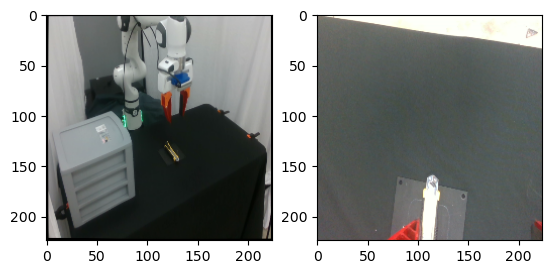

In [19]:
plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [20]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]

    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

In [21]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
agentview_rgb (1, 3, 224, 224)
eye_in_hand_rgb (1, 3, 224, 224)


### Now load dp policy

In [22]:
# checkpoint = "/home/franka_deoxys/data_franka/dp_policy/bell180_after_train.ckpt"

# checkpoint = "/home/franka_deoxys/data_franka/60_bellpepper.ckpt"
checkpoint = "/home/franka_deoxys/data_franka/100_drawer_ola.ckpt"
 
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg'] 
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['ee_states', 'joint_states', 'gripper_states']
using obs modality: rgb with keys: ['agentview_rgb', 'eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/miniconda3/envs/robodiff/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 2.564722e+08
Vision params: 2.239418e+07


In [23]:
# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()
pass 

In [24]:
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action( action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        # dual arm
        action = action.reshape(-1,2,10)

    d_rot = action.shape[-1] - 4
    pos = action[...,:3]
    rot = action[...,3:3+d_rot]
    gripper = action[...,[-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([
        pos, rot, gripper
    ], axis=-1)

    if raw_shape[-1] == 20:
        # dual arm
        uaction = uaction.reshape(*raw_shape[:-1], 14)

    return uaction


In [18]:
# dataset_path="/media/franka_deoxys/DATA/demo_rss_paper/dec20/hdfs/ola_114.hdf5"

# f= h5py.File(dataset_path, 'r')
# demos= f['data']
# len(demos)

In [19]:
# demo=f['data']['demo_1']
# actions_org=demo['actions']
# obss=demo['obs']
# actions_org.shape

In [25]:
def predict_action(obs):
    """ 
    obs: 2x...
    """
    np_obs_dict = {key:obs[key] for key in keys_select}
    obs_dict = dict_apply(np_obs_dict, 
        lambda x: torch.from_numpy(x).to(
            device=device))

    for key in obs_dict.keys():
        obs_dict[key]=obs_dict[key].unsqueeze(0) 

    
    with torch.no_grad():
        action_dict = policy.predict_action(obs_dict)

    # device_transfer
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().to('cpu').numpy())


    # step env
    env_action =  np_action_dict['action']
    env_action = undo_transform_action(env_action)

    env_action=env_action.squeeze()
    return env_action

In [26]:
framestacker=FrameStackForTrans(2)
keys_select = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

In [22]:
# i=0
# obs = {k: obss[k][i] for k in obss.keys()}
# obs['agentview_rgb'] = obs['agentview_rgb'].transpose(2,0,1)
# obs['eye_in_hand_rgb'] = obs['eye_in_hand_rgb'].transpose(2,0, 1)

# for k in obs.keys():
#     print(k, obs[k].shape)

In [27]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys(): 
    print(key, obs_dict[key].shape)

ee_states (16,)
joint_states (7,)
gripper_states (1,)
agentview_rgb (3, 224, 224)
eye_in_hand_rgb (3, 224, 224)


In [24]:
# action_pred=predict_action(obs)

In [25]:
# action_pred.shape

In [28]:
framestacker=FrameStackForTrans(2) 
policy.reset()

obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)

In [29]:
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)
action_pred=predict_action(obs)

In [30]:
action_pred

array([[-0.068,  0.225, -0.449,  0.016,  0.006,  0.004, -0.996],
       [-0.081,  0.199, -0.449,  0.014,  0.003,  0.003, -0.996],
       [-0.101,  0.177, -0.444,  0.01 ,  0.007,  0.003, -0.997],
       [-0.129,  0.151, -0.443,  0.004,  0.01 ,  0.003, -0.998],
       [-0.179,  0.114, -0.445, -0.002,  0.004,  0.004, -0.998],
       [-0.212,  0.092, -0.45 , -0.008, -0.001,  0.001, -0.996],
       [-0.247,  0.078, -0.457, -0.015, -0.001,  0.   , -0.997],
       [-0.287,  0.057, -0.465, -0.018, -0.007, -0.003, -0.997]],
      dtype=float32)

In [31]:
for act in action_pred:  
    print(act.shape)

(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)
(7,)


In [30]:
policy.reset()
 
for _ in range(500):
    action, grasp = input2action(
        device=spacemouse,
        controller_type=controller_type,
    )
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    obs_dict=get_current_obs(robot_interface)
    obs = framestacker.add_new_obs(obs_dict)
    action_pred=predict_action(obs)

    # print(f'actions: {action[0]:.3f} {action[1]:.3f} {action[2]:.3f} {action[-1]:.3f}')
    
    for action in action_pred:  
        robot_interface.control(
            controller_type=controller_type,
            action=action,
            controller_cfg=controller_cfg,
        )

    # time.sleep(0.045)

    
robot_interface.close()